# Notebook for analysing results of the learned Q value functions in the "Communication for goal alignment" strategy

This notebook can be used for visualizing how the leader sets the goal of the follower and computing percentages of alignment and sub goal decomposition (i.e leader 101 -> follower 001)

In [6]:
import os
import random
import tempfile
from copy import deepcopy
from datetime import datetime

import click
import imgc_marl.envs.population as population
import numpy as np
import yaml
from imgc_marl.callbacks import (
    PopGoalLinesCallback,
    PopGoalLinesCommunicationCallback,
    PopGoalLinesNamingCallback,
    PopGoalLinesNamingCallback1Matrix,
)
from imgc_marl.evaluation import (
    communication_custom_eval_function,
    custom_eval_function,
)
from imgc_marl.models.basic_communication import BasicCommunicationNetwork
from imgc_marl.models.full_naming_game import FullNamingNetwork
from imgc_marl.models.full_naming_game_single_matrix import FullNamingNetwork1Matrix
from imgc_marl.policies.basic_communication import BasicCommunicationTrainer
from imgc_marl.policies.full_naming_game import FullNamingTrainer
from imgc_marl.policies.full_naming_game_single_matrix import FullNamingTrainer1Matrix
from imgc_marl.utils import keep_relevant_results
from ray.rllib.agents.ppo import DEFAULT_CONFIG, PPOTrainer
from ray.rllib.models import ModelCatalog
from ray.rllib.policy.policy import PolicySpec
from ray.tune.logger import UnifiedLogger, pretty_print

import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

* Select correct configuration file 
* Select environment (3 or 6 landmarks)
* Select the checkpoint you want to evaluate

In [7]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
config_file = "goal_lines_communication.yml"
environment = PopGoalLinesEnv

# 6 landmarks
# config_file = "large_goal_lines_naming.yml"
# environment = PopLargeGoalLinesEnv


# directory of the checkpoint you want to evaluate
checkpoint_dir = "/home/elias/september/3_landmarks/classic_reward/2/communication/2022-09-21_12-57-19gzsmr3rx/checkpoint_000300/checkpoint-300"

Loading the model ...

In [8]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = population.LARGE_GOAL_LINES_TIMELIMIT
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model(
    "BasicCommunicationNetwork", BasicCommunicationNetwork
)
n_goals = environment(config["env_config"]).goal_space_dim
goal_repr_dim = environment(config["env_config"]).goal_repr_dim
goal_space = environment(config["env_config"]).goal_space
config["model"] = {
    "custom_model": "BasicCommunicationNetwork",
    "custom_model_config": {
        "number_of_messages": n_goals,
        "input_dim": goal_repr_dim,
    },
}
trainer = BasicCommunicationTrainer(
    config=config,
    env=train_env,
)
trainer.restore(checkpoint_dir)

2022-09-30 15:59:20,102	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-09-30 15:59:20,103	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-09-30 15:59:20,103	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-09-30 15:59:20,104	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-09-30 15:59:20,105	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-09-30 15:59:20,110	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-09-30 15:59:20,120	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-09-30 15:59:22,834	INFO trainable.py:588 -- Restored on 193.50.110.220 from checkpoint: /home/elias/

## Inspecting how the leader assign goals for the follower for all possible combinations
* Alignment will store the % of goals for which the leader chooses the same goal for the follower when the leader has a cooperative goal
* Subgoal will store the % of goals for which the leader chooses a correct sub goal for the follower or a cooperative goal compatible with the leader's individual goal
* Individual will store the different goals the leader assign to the follower when he received an individual goal (to check that this is kind of uniform)

In [9]:
# All goals (all possible inputs a leader can have)
possible_messages = torch.nn.functional.one_hot(
    torch.arange(0, n_goals),
).float()
possible_goals = torch.tensor(goal_space, dtype=torch.float)
alignment = []
subgoal = []
individual = []

In [13]:
agent_names = [a.name for a in train_env(config["env_config"]).population]
# Goal selected by each agent when it's a leader for each possible sampled goal
predictions = [
    trainer.get_policy(agent_name).model._communication_branch(possible_goals).argmax(1)
    for agent_name in agent_names
]

In [31]:
for i, pn in enumerate(zip(*predictions)):
    leader_goal = goal_space[i]
    print(f"LEADER GOAL: {leader_goal}")
    follower_goals = []
    for p in pn:
        follower_goals.append(goal_space[p])
    print(f"FOLLOWER GOALS: {follower_goals}")
    if sum(leader_goal) > 1:
        # cooperative goals, thus we compute alignment
        for g in follower_goals:
            alignment.append(np.all(leader_goal == g))
            subgoal.append(np.bitwise_xor.reduce([leader_goal, g]).sum() == 1)
    else:
        for p in pn:
            individual.append(p.item())
        for g in follower_goals:
            if sum(g) > 1:
                alignment.append(0)
            subgoal.append(np.bitwise_xor.reduce([leader_goal, g]).sum() == 1)
    print("---------------------------")

LEADER GOAL: [0, 0, 1]
FOLLOWER GOALS: [[0, 1, 0], [0, 1, 0]]
---------------------------
LEADER GOAL: [0, 1, 0]
FOLLOWER GOALS: [[0, 1, 1], [0, 1, 1]]
---------------------------
LEADER GOAL: [1, 0, 0]
FOLLOWER GOALS: [[0, 1, 1], [1, 0, 1]]
---------------------------
LEADER GOAL: [0, 1, 1]
FOLLOWER GOALS: [[0, 1, 1], [0, 1, 1]]
---------------------------
LEADER GOAL: [1, 0, 1]
FOLLOWER GOALS: [[1, 0, 1], [1, 0, 1]]
---------------------------
LEADER GOAL: [1, 1, 0]
FOLLOWER GOALS: [[1, 1, 0], [1, 1, 0]]
---------------------------


In [33]:
print(f"Alignment: {sum(alignment)/len(alignment)}")
print(f"Subgoals: {sum(subgoal)/len(subgoal)}")

Alignment: 0.8571428571428571
Subgoals: 0.16666666666666666


Text(0.5, 0, 'Goal index')

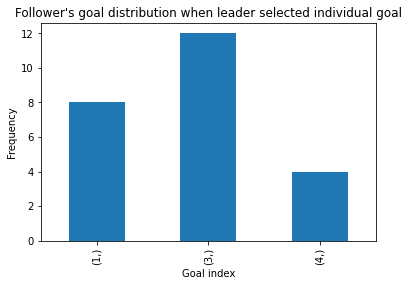

In [35]:
pd.DataFrame(individual).value_counts().sort_index().plot.bar()
plt.title("Follower's goal distribution when leader selected individual goal")
plt.ylabel("Frequency")
plt.xlabel("Goal index")